# Calibration

In [174]:
import matplotlib.pyplot as pyplt

pyplt.rcParams["figure.figsize"] = (20, 8)

⚙  core/io.py:119 Loaded study with 0.0229% error rate


132.39255768184444 55
156.54527696116367 56
185.94648103131686 43
165.26582083004286 57
157.66417336577103 57
36.720443734795595 26
148.23270927727708 55
191.45124696012408 69
174.05286535922926 60
64.42752666495608 29


0.05626675613269061

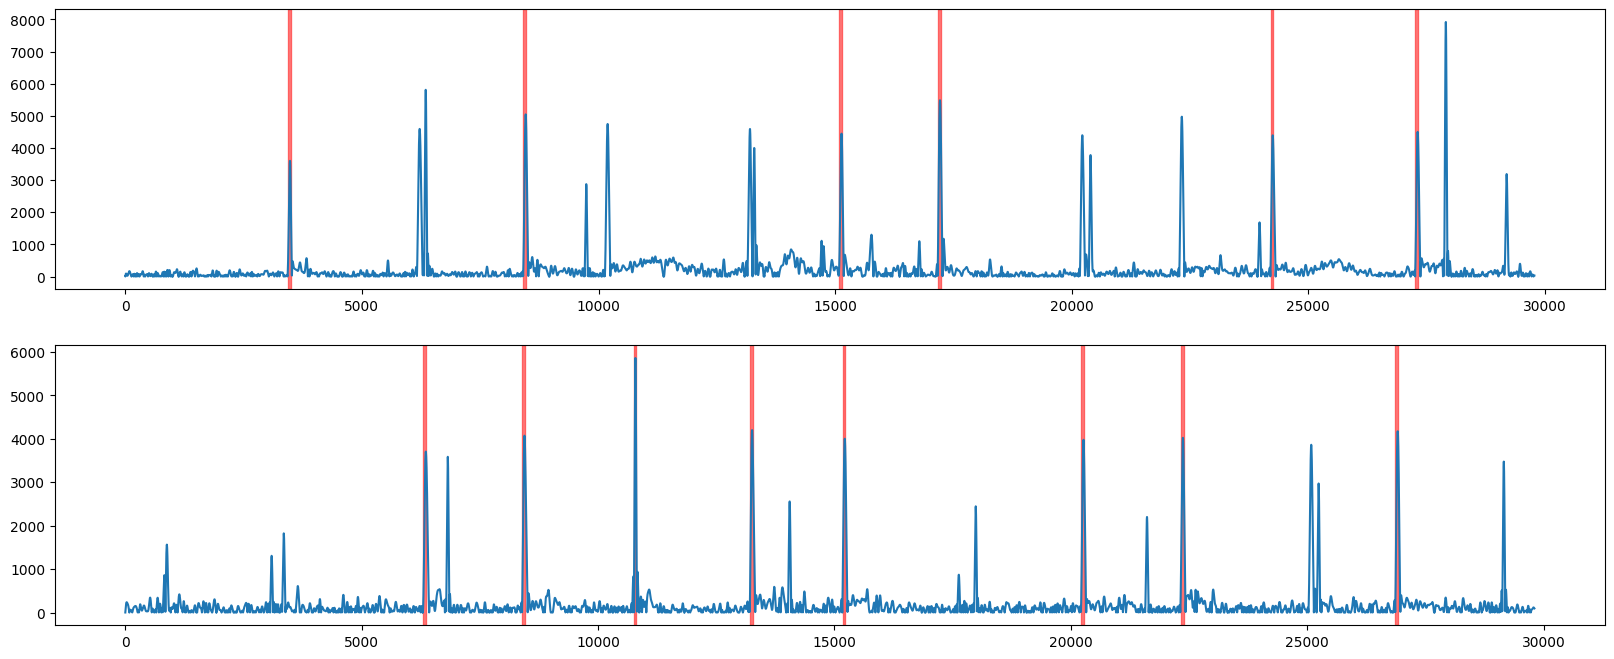

In [244]:
import numpy as np

from openeog.core.io import load_study
from openeog.core.differentiation import differentiate
from openeog.core.denoising import denoise_35
from openeog.core.models import Study, Test
from scipy import signal

hc1 = study[0]
hc2 = study[-1]

def find_peaks(
    channel: np.ndarray, 
    width: int=200, # In miliseconds
) -> tuple[
    list[int],   # Peaks found
    np.ndarray,  # Absolute velocity channel
]:
    # Encontrar los picos para saber donde buscar
    vel_channel = abs(denoise_35(differentiate(channel)))
    
    peaks = signal.find_peaks_cwt(vel_channel, width)
    return peaks, vel_channel


def climb_peak(
    vel_channel: np.ndarray,
    position: int,
) -> int:
    max_position = len(vel_channel) - 1
    while position > 0 and position < max_position:
        current_value = vel_channel[position]
        left_value = vel_channel[position - 1]
        right_value = vel_channel[position + 1]
        if left_value > right_value > current_value:
            position -= 1
        elif right_value > left_value > current_value:
            position += 1
        else:
            return position


def filter_by_median(
    vel_channel: np.ndarray,
    peaks: list[int],
    span: float = 0.5
) -> tuple[
    list[int],
    float, # Median
]:
    # Filtrar por mediana para eliminar outliers
    peak_values = [vel_channel[peak] for peak in peaks]
    median_peak = np.median(peak_values)
    
    max_value = median_peak * (1.0 + span)
    min_value = median_peak * (1.0 - span)

    return [
        peak
        for peak in peaks
        if max_value >= vel_channel[peak] >= min_value
    ], median_peak


def peak_range(
    vel_channel: np.ndarray,
    position: int,
    threshold=300,
) -> tuple[int, int]:
    left = position - 1
    while left > 0 and vel_channel[left - 1] > threshold:
        left -= 1
        
    right = position + 1
    max_position = len(vel_channel) - 1
    while right < max_position and vel_channel[right + 1] < threshold:
        right += 1

    return left, right


def filter_features(
    hor_channel: np.ndarray,
    impulses: list[tuple[int, int]],
    debug: bool = False,
) -> tuple[
    list[tuple[int, int]],
    list[float], # Amplitudes
]:
    result = []
    amplitudes = []
    for onset, offset in impulses:
        amplitude = abs(hor_channel[onset] - hor_channel[offset])
        duration = offset - onset

        if debug:
            print(amplitude, duration)

        if amplitude < 100:
            continue

        if amplitude > 300:
            continue

        if duration < 40:
            continue

        if duration > 70:
            continue
            
        result.append((onset, offset))
        amplitudes.append(amplitude)
        
    return result, amplitudes


def calibrate(
    study: Study, 
    angle: float = 30.0,
    plot: bool = False
) -> float: # Calibration difference
    hc1 = study[0]

    hor_channel1 = hc1._hor_channel
    peaks1, vel_channel1 = find_peaks(hor_channel1)
    max_peaks1 = [climb_peak(vel_channel1, peak) for peak in peaks1]
    filtered_peaks1, median_peak1 = filter_by_median(vel_channel1, max_peaks1)
    impulses1 = [peak_range(vel_channel1, peak) for peak in filtered_peaks1]
    filtered_impulses1, amplitudes1 = filter_features(hor_channel1, impulses1)
    if amplitudes1:
        amplitudes_mean1 = np.mean(amplitudes1)
    else:
        amplitudes_mean1 = 0.0

    hc2 = study[-1]

    hor_channel2 = hc2._hor_channel
    peaks2, vel_channel2 = find_peaks(hor_channel2)
    max_peaks2 = [climb_peak(vel_channel2, peak) for peak in peaks2]
    filtered_peaks2, median_peak2 = filter_by_median(vel_channel2, max_peaks2)
    impulses2 = [peak_range(vel_channel2, peak) for peak in filtered_peaks2]
    filtered_impulses2, amplitudes2 = filter_features(hor_channel2, impulses2, debug=True)

    if amplitudes2:
        amplitudes_mean2 = np.mean(amplitudes2)
    else:
        amplitudes_mean2 = 0.0

    if amplitudes1 and amplitudes2:
        difference = abs(1.0 - amplitudes_mean1 / amplitudes_mean2) * 100.0
    else:
        difference = 100.0
    
    aggregated_mean = np.mean(amplitudes1 + amplitudes2)

    study._hor_calibration = angle / aggregated_mean
    study._hor_calibration_diff = difference

    if plot:
        plt.subplot(211)
        plt.plot(vel_channel1)
        for onset, offset in filtered_impulses1:
            plt.axvspan(onset, offset, color='r', alpha=0.5)

        plt.subplot(212)
        plt.plot(vel_channel2)
        for onset, offset in filtered_impulses2:
            plt.axvspan(onset, offset, color='r', alpha=0.5)

            
    return difference / 100.0


study = load_study("/Users/idertator/Registros/july2024/antisaccades/fixed/Prueba_Antisacadica_21.oeog")
calibrate(study, plot=True)